# Инференс обученной модели + градио демо


In [1]:
#!g2.1
%pip install gradio

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 638.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 1.9 MB/s eta 0:00:0000:010:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.
spacy 3.5.4 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.5.1 which is incompatible.

[notice] A new release of 

In [2]:
#!g2.1
import os
import sys

import fire
import gradio as gr
import torch
import transformers
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer

In [3]:
#!g2.1
from typing import Union

class Prompter(object):
    
    def generate_prompt(
        self,
        instruction: str,
        label: Union[None, str] = None,
    ) -> str:     

        res = f"{instruction}\nAnswer: "
               
        if label:
            res = f"{res}{label}"
         
        return res


    def get_response(self, output: str) -> str:
        return output.split("Answer:")[1].strip().replace("/", "\u00F7").replace("*", "\u00D7")

In [4]:
#!g2.1
import warnings
warnings.filterwarnings("ignore")

In [5]:
#!g2.1
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
#!g2.1
base_model = "baffo32/decapoda-research-llama-7B-hf"
lora_weights = "Shakhovak/HW5_Llama2_arithmetic"  # новый чек-пойнт после доп обучения 'Shakhovak/HW5_Llama2_arithmetic_2'
prompter = Prompter()
tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b")

model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
model = PeftModel.from_pretrained(
    model,
    lora_weights,
    torch_dtype=torch.float16,
    device_map={"": 0},
)

model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear8bitLt(
                (lora_drop

In [7]:
#!g2.1
def evaluat(
    text,
    temperature=0.1,
    do_sample = True,
    top_p=0.75,
    top_k=40,
    num_beams=2,
    max_new_tokens=512,
    stream_output=True,
    **kwargs,
):
    prompt = prompter.generate_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )

    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
    }

    # Without streaming
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True).strip()
    
    return prompter.get_response(output)

In [8]:
#!g2.1
from datasets import load_from_disk

val_data = load_from_disk("val_data.hf")
val_data

Dataset({
    features: ['output', 'answer', 'input', 'instruction', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 73
})

In [9]:
#!g2.1
from tqdm import tqdm_notebook
answers = []
for i in tqdm_notebook(val_data):
    answers.append(evaluat(i['instruction']))

  0%|          | 0/73 [00:00<?, ?it/s]

2023-11-16 10:28:53.709945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
#!g2.1
import evaluate
metric = evaluate.load("exact_match")

In [11]:
#!g2.1
texts_together = []
count = 0
for i in val_data['output']:
  for j in answers:
    
    if val_data['output'].index(i) == answers.index(j):
        j = j.replace('×', '*').replace('÷', '/')
        if metric.compute(predictions=[j], references=[i])['exact_match'] == 1.0:
            count += 1
        texts_together.append((i,j,metric.compute(predictions=[j], references=[i]) ))

display(f'Total % of correct answers: {count/len(texts_together)}')
display('=======================')
for i in texts_together:
    display(i)
    display('===========================')

'Total % of correct answers: 0.4657534246575342'

'======================='

('91 * 94 = 94 * (90 + 1) = 94 * 90 + 94 * 1 = 8460 + 94 = 8554',
 '91 * 94 = 94 * (90 + 1) = 94 * 90 + 94 * 1 = 8460 + 94 = 8554',
 {'exact_match': 1.0})

'==========================='

('8387734 + 294 = 8388028', '8387734 + 294 = 8387763', {'exact_match': 0.0})

'==========================='

('1437 / 4 = 359 R 1', '1437 / 4 = 360 R 3', {'exact_match': 0.0})

'==========================='

('3778175 / 5 = 755635', '3778175 / 5 = 755635', {'exact_match': 1.0})

'==========================='

('1336951 - 673 * 1000 = 1336951 - 673000 = 663951\n663951 - 673 * 900 = 663951 - 605700 = 58251\n58251 - 673 * 80 = 58251 - 53840 = 4411\n4411 - 673 * 6 = 4411 - 4038 = 373\nTherefore, 1336951 / 673 = 1986 R 373',
 '1336951 - 673 * 2000 = 1336951 - 1346000 = 10451\n10451 - 673 * 10 = 10451 - 6730 = 3721\n3721 - 673 * 5 = 3721 - 3365 = 356\nTherefore, 1336951 / 673 = 1989 R 356',
 {'exact_match': 0.0})

'==========================='

('4968103886 / 9 = 552011542 R 8',
 '4968103886 / 9 = 557666509 R 6',
 {'exact_match': 0.0})

'==========================='

('5250365 + 499969 = 5750334',
 '5250365 + 499969 = 5740334',
 {'exact_match': 0.0})

'==========================='

('71810 - 68 * 1000 = 71810 - 68000 = 3810\n3810 - 68 * 50 = 3810 - 3400 = 410\n410 - 68 * 6 = 410 - 408 = 2\nTherefore, 71810 / 68 = 1056 R 2',
 '71810 - 68 * 1000 = 71810 - 68000 = 3810\n3810 - 68 * 50 = 3810 - 3400 = 410\n410 - 68 * 6 = 410 - 412 = -2\nTherefore, 71810 / 68 = 1050 R 2',
 {'exact_match': 0.0})

'==========================='

('84782 * 4 = 339128', '84782 * 4 = 339128', {'exact_match': 1.0})

'==========================='

('86098 - 2035911 = -1949813',
 '86098 - 2035911 = -1950813',
 {'exact_match': 0.0})

'==========================='

('123624 - 303 * 400 = 123624 - 121200 = 2424\n2424 - 303 * 8 = 2424 - 2424 = 0\nTherefore, 123624 / 303 = 408',
 '123624 - 303 * 400 = 123624 - 121200 = 2424\n2424 - 303 * 8 = 2424 - 2424 = 0\nTherefore, 123624 / 303 = 408',
 {'exact_match': 1.0})

'==========================='

('15856 - 36855443 = -36839587',
 '15856 - 36855443 = -36839587',
 {'exact_match': 1.0})

'==========================='

('985125 - 248445 * 3 = 985125 - 745335 = 239790\nTherefore, 985125 / 248445 = 3 R 239790',
 '985125 - 248445 * 4 = 985125 - 999780 = -14655\nTherefore, 985125 / 248445 = 3 R 14655',
 {'exact_match': 0.0})

'==========================='

('1 - 9854569779 = -9854569778',
 '1 - 9854569779 = -9854569778',
 {'exact_match': 1.0})

'==========================='

('964922128 - 368 * 2000000 = 964922128 - 736000000 = 228922128\n228922128 - 368 * 600000 = 228922128 - 220800000 = 8122128\n8122128 - 368 * 20000 = 8122128 - 7360000 = 762128\n762128 - 368 * 2000 = 762128 - 736000 = 26128\n26128 - 368 * 70 = 26128 - 25760 = 368\n368 - 368 * 1 = 368 - 368 = 0\nTherefore, 964922128 / 368 = 2622071',
 '964922128 - 368 * 2000000 = 964922128 - 736000000 = 228922128\n228922128 - 368 * 600000 = 228922128 - 210800000 = 18122128\n18122128 - 368 * 40000 = 18122128 - 14720000 = 3402128\n3402128 - 368 * 9000 = 3402128 - 3312000 = 90128\n90128 - 368 * 200 = 90128 - 73600 = 16528\n16528 - 368 * 40 = 16528 - 14720 = 1808\n1808 - 368 * 4 = 1808 - 1472 = 336\nTherefore, 964922128 / 368 = 2618888 R 336',
 {'exact_match': 0.0})

'==========================='

('3506592 * 32 = 3506592 * (30 + 2) = 3506592 * 30 + 3506592 * 2 = 105197760 + 7013184 = 112210944',
 '3506592 * 32 = 3506592 * (30 + 2) = 3506592 * 30 + 3506592 * 2 = 105207760 + 7013184 = 112220944',
 {'exact_match': 0.0})

'==========================='

('96440689 / 1 = 96440689', '96440689 / 1 = 96440689', {'exact_match': 1.0})

'==========================='

('38 + 23 = 61', '38 + 23 = 61', {'exact_match': 1.0})

'==========================='

('42459 * 60251 = 60251 * (40000 + 2000 + 400 + 50 + 9) = 60251 * 40000 + 60251 * 2000 + 60251 * 400 + 60251 * 50 + 60251 * 9 = 2410040000 + 120502000 + 24100400 + 3012550 + 542259 = 2530542000 + 24100400 + 3012550 + 542259 = 2554642400 + 3012550 + 542259 = 2557654950 + 542259 = 2558197209',
 '42459 * 60251 = 60251 * (40000 + 2000 + 400 + 50 + 9) = 60251 * 40000 + 60251 * 2000 + 60251 * 400 + 60251 * 50 + 60251 * 9 = 2410040000 + 120502000 + 24100400 + 3012550 + 542259 = 2530542000 + 24100400 + 3012550 + 542259 = 2554642400 + 3012550 + 542259 = 2557654950 + 542259 = 2558197209',
 {'exact_match': 1.0})

'==========================='

('49063172 - 82849401 = -33786229',
 '49063172 - 82849401 = -33786229',
 {'exact_match': 1.0})

'==========================='

('8346712152 - 2276275285 = 6070436867',
 '8346712152 - 2276275285 = 6070436867',
 {'exact_match': 1.0})

'==========================='

('6819277 + 78939 = 6898216',
 '6819277 + 78939 = 6898216',
 {'exact_match': 1.0})

'==========================='

('2736910184 + 5247771440 = 7984681624',
 '2736910184 + 5247771440 = 7984681624',
 {'exact_match': 1.0})

'==========================='

('634383204 - 659442 * 900 = 634383204 - 593497800 = 40885404\n40885404 - 659442 * 60 = 40885404 - 39566520 = 1318884\n1318884 - 659442 * 2 = 1318884 - 1318884 = 0\nTherefore, 634383204 / 659442 = 962',
 '634383204 - 659442 * 900 = 634383204 - 593497800 = 40885404\n40885404 - 659442 * 60 = 40885404 - 39566520 = 1318884\n1318884 - 659442 * 2 = 1318884 - 1318884 = 0\nTherefore, 634383204 / 659442 = 966',
 {'exact_match': 0.0})

'==========================='

('800761203 + 15696773 = 816457976',
 '800761203 + 15696773 = 816458076',
 {'exact_match': 0.0})

'==========================='

('38184 * 16348 = 38184 * (10000 + 6000 + 300 + 40 + 8) = 38184 * 10000 + 38184 * 6000 + 38184 * 300 + 38184 * 40 + 38184 * 8 = 381840000 + 229104000 + 11455200 + 1527360 + 305472 = 610944000 + 11455200 + 1527360 + 305472 = 622399200 + 1527360 + 305472 = 623926560 + 305472 = 624232032',
 '38184 * 16348 = 38184 * (10000 + 6000 + 300 + 40 + 8) = 38184 * 10000 + 38184 * 6000 + 38184 * 300 + 38184 * 40 + 38184 * 8 = 381840000 + 229084000 + 11454200 + 1527360 + 304672 = 610924000 + 11454200 + 1527360 + 304672 = 622378200 + 1527360 + 304672 = 623905560 + 304672 = 624210232',
 {'exact_match': 0.0})

'==========================='

('3186 / 5 = 637 R 1', '3186 / 5 = 637 R 2', {'exact_match': 0.0})

'==========================='

('74487364 * 40000 = 2979494560000',
 '74487364 * 40000 = 2979494560000',
 {'exact_match': 1.0})

'==========================='

('802752388 + 787260412 = 1590012800',
 '802752388 + 787260412 = 1600012790',
 {'exact_match': 0.0})

'==========================='

('51231796 - 902 * 50000 = 51231796 - 45100000 = 6131796\n6131796 - 902 * 6000 = 6131796 - 5412000 = 719796\n719796 - 902 * 700 = 719796 - 631400 = 88396\n88396 - 902 * 90 = 88396 - 81180 = 7216\n7216 - 902 * 8 = 7216 - 7216 = 0\nTherefore, 51231796 / 902 = 56798',
 '51231796 - 902 * 50000 = 51231796 - 45100000 = 6131796\n6131796 - 902 * 6000 = 6131796 - 5412000 = 719796\n719796 - 902 * 700 = 719796 - 631400 = 88396\n88396 - 902 * 90 = 88396 - 81180 = 7216\n7216 - 902 * 8 = 7216 - 7216 = 0\nTherefore, 51231796 / 902 = 56806',
 {'exact_match': 0.0})

'==========================='

('765555 - 548 = 765007', '765555 - 548 = 765007', {'exact_match': 1.0})

'==========================='

('5571475 - 2015 * 2000 = 5571475 - 4030000 = 1541475\n1541475 - 2015 * 700 = 1541475 - 1410500 = 130975\n130975 - 2015 * 60 = 130975 - 120900 = 10075\n10075 - 2015 * 5 = 10075 - 10075 = 0\nTherefore, 5571475 / 2015 = 2765',
 '5571475 - 2015 * 2000 = 5571475 - 4030000 = 1541475\n1541475 - 2015 * 700 = 1541475 - 1410500 = 130975\n130975 - 2015 * 60 = 130975 - 120900 = 10075\n10075 - 2015 * 5 = 10075 - 10075 = 0\nTherefore, 5571475 / 2015 = 2791',
 {'exact_match': 0.0})

'==========================='

('93853144080 - 899998 * 100000 = 93853144080 - 89999800000 = 3853344080\n3853344080 - 899998 * 4000 = 3853344080 - 3599992000 = 253352080\n253352080 - 899998 * 200 = 253352080 - 179999600 = 73352480\n73352480 - 899998 * 80 = 73352480 - 71999840 = 1352640\n1352640 - 899998 * 1 = 1352640 - 899998 = 452642\nTherefore, 93853144080 / 899998 = 104281 R 452642',
 '93853144080 - 899998 * 100000 = 93853144080 - 89999800000 = 3853344080\n3853344080 - 899998 * 4000 = 3853344080 - 3599992000 = 253352080\n253352080 - 899998 * 200 = 253352080 - 179999600 = 73352480\n73352480 - 899998 * 80 = 73352480 - 71999840 = 1352640\n1352640 - 899998 * 1 = 1352640 - 899998 = 452642\nTherefore, 93853144080 / 899998 = 104816 R 452642',
 {'exact_match': 0.0})

'==========================='

('19 * 6 = 114', '19 * 6 = 114', {'exact_match': 1.0})

'==========================='

('6793748 / 3 = 2264582 R 2', '6793748 / 3 = 2264246', {'exact_match': 0.0})

'==========================='

('7670875033 - 1757206934 = 5913668099',
 '7670875033 - 1757206934 = 5913668099',
 {'exact_match': 1.0})

'==========================='

('49 * 60140196 = 60140196 * (40 + 9) = 60140196 * 40 + 60140196 * 9 = 2405607840 + 541261764 = 2946869604',
 '49 * 60140196 = 60140196 * (40 + 9) = 60140196 * 40 + 60140196 * 9 = 2405607840 + 541261764 = 2946869504',
 {'exact_match': 0.0})

'==========================='

('621 * 9003746 = 9003746 * (600 + 20 + 1) = 9003746 * 600 + 9003746 * 20 + 9003746 * 1 = 5402247600 + 180074920 + 9003746 = 5582322520 + 9003746 = 5591326266',
 '621 * 9003746 = 9003746 * (600 + 20 + 1) = 9003746 * 600 + 9003746 * 20 + 9003746 * 1 = 5402247600 + 180074920 + 9003746 = 5582322520 + 9003746 = 5591326266',
 {'exact_match': 1.0})

'==========================='

('930020 - 260 * 3000 = 930020 - 780000 = 150020\n150020 - 260 * 500 = 150020 - 130000 = 20020\n20020 - 260 * 70 = 20020 - 18200 = 1820\n1820 - 260 * 7 = 1820 - 1820 = 0\nTherefore, 930020 / 260 = 3577',
 '930020 - 260 * 3000 = 930020 - 780000 = 150020\n150020 - 260 * 500 = 150020 - 130000 = 20020\n20020 - 260 * 70 = 20020 - 18200 = 1820\n1820 - 260 * 7 = 1820 - 1820 = 0\nTherefore, 930020 / 260 = 3600',
 {'exact_match': 0.0})

'==========================='

('5349432924 - 550605 * 9000 = 5349432924 - 4955445000 = 393987924\n393987924 - 550605 * 700 = 393987924 - 385423500 = 8564424\n8564424 - 550605 * 10 = 8564424 - 5506050 = 3058374\n3058374 - 550605 * 5 = 3058374 - 2753025 = 305349\nTherefore, 5349432924 / 550605 = 9715 R 305349',
 '5349432924 - 550605 * 9000 = 5349432924 - 5055445000 = 293987924\n293987924 - 550605 * 500 = 293987924 - 275302500 = 18685424\n18685424 - 550605 * 30 = 18685424 - 16518150 = 2167274\n2167274 - 550605 * 4 = 2167274 - 2202420 = -35148\nTherefore, 5349432924 / 550605 = 9691 R 35148',
 {'exact_match': 0.0})

'==========================='

('263920 - 58 * 4000 = 263920 - 232000 = 31920\n31920 - 58 * 500 = 31920 - 29000 = 2920\n2920 - 58 * 50 = 2920 - 2900 = 20\nTherefore, 263920 / 58 = 4550 R 20',
 '263920 - 58 * 4000 = 263920 - 232000 = 31920\n31920 - 58 * 500 = 31920 - 29000 = 2920\n2920 - 58 * 50 = 2920 - 2900 = 20\nTherefore, 263920 / 58 = 4440 R 20',
 {'exact_match': 0.0})

'==========================='

('3175 * 6059 = 6059 * (3000 + 100 + 70 + 5) = 6059 * 3000 + 6059 * 100 + 6059 * 70 + 6059 * 5 = 18177000 + 605900 + 424130 + 30295 = 18782900 + 424130 + 30295 = 19207030 + 30295 = 19237325',
 '3175 * 6059 = 6059 * (3000 + 100 + 70 + 5) = 6059 * 3000 + 6059 * 100 + 6059 * 70 + 6059 * 5 = 18177000 + 605900 + 424130 + 30295 = 18782900 + 424130 + 30295 = 19207030 + 30295 = 19237325',
 {'exact_match': 1.0})

'==========================='

('31555 - 44 * 700 = 31555 - 30800 = 755\n755 - 44 * 10 = 755 - 440 = 315\n315 - 44 * 7 = 315 - 308 = 7\nTherefore, 31555 / 44 = 717 R 7',
 '31555 - 44 * 700 = 31555 - 30800 = 755\n755 - 44 * 10 = 755 - 440 = 315\n315 - 44 * 7 = 315 - 308 = 7\nTherefore, 31555 / 44 = 710 R 7',
 {'exact_match': 0.0})

'==========================='

('563 * 539 = 563 * (500 + 30 + 9) = 563 * 500 + 563 * 30 + 563 * 9 = 281500 + 16890 + 5067 = 298390 + 5067 = 303457',
 '563 * 539 = 563 * (500 + 30 + 9) = 563 * 500 + 563 * 30 + 563 * 9 = 281500 + 16890 + 4967 = 308390 + 4967 = 313357',
 {'exact_match': 0.0})

'==========================='

('33582 - 3910063 = -3876481',
 '33582 - 3910063 = -3876481',
 {'exact_match': 1.0})

'==========================='

('346 * 21 = 346 * (20 + 1) = 346 * 20 + 346 * 1 = 6920 + 346 = 7266',
 '346 * 21 = 346 * (20 + 1) = 346 * 20 + 346 * 1 = 6920 + 346 = 7266',
 {'exact_match': 1.0})

'==========================='

('7663 - 46 = 7617', '7663 - 46 = 7617', {'exact_match': 1.0})

'==========================='

('6855552 / 8 = 856944', '6855552 / 8 = 869111 R 6', {'exact_match': 0.0})

'==========================='

('2282 * 99281 = 99281 * (2000 + 200 + 80 + 2) = 99281 * 2000 + 99281 * 200 + 99281 * 80 + 99281 * 2 = 198562000 + 19856200 + 7942480 + 198562 = 218418200 + 7942480 + 198562 = 226360680 + 198562 = 226559242',
 '2282 * 99281 = 99281 * (2000 + 200 + 80 + 2) = 99281 * 2000 + 99281 * 200 + 99281 * 80 + 99281 * 2 = 198562000 + 19856200 + 7950480 + 198562 = 218418200 + 7950480 + 198562 = 226368680 + 198562 = 226567242',
 {'exact_match': 0.0})

'==========================='

('827147620 / 10 = 82714762',
 '827147620 / 10 = 82714762',
 {'exact_match': 1.0})

'==========================='

('0 * 417258 = 0', '0 * 417258 = 0', {'exact_match': 1.0})

'==========================='

('937536067 - 390913909 = 546622158',
 '937536067 - 390913909 = 546622158',
 {'exact_match': 1.0})

'==========================='

('1534231566 * 9 = 13808084094',
 '1534231566 * 9 = 13808084194',
 {'exact_match': 0.0})

'==========================='

('62441 - 9992511 = -9930070',
 '62441 - 9992511 = -9930070',
 {'exact_match': 1.0})

'==========================='

('364 + 421650124 = 421650488',
 '364 + 421650124 = 421650488',
 {'exact_match': 1.0})

'==========================='

('16 - 238 = -222', '16 - 238 = -222', {'exact_match': 1.0})

'==========================='

('74793 - 50 * 1000 = 74793 - 50000 = 24793\n24793 - 50 * 400 = 24793 - 20000 = 4793\n4793 - 50 * 90 = 4793 - 4500 = 293\n293 - 50 * 5 = 293 - 250 = 43\nTherefore, 74793 / 50 = 1495 R 43',
 '74793 - 50 * 1000 = 74793 - 50000 = 24793\n24793 - 50 * 400 = 24793 - 20000 = 4793\n4793 - 50 * 90 = 4793 - 4500 = 293\n293 - 50 * 5 = 293 - 250 = 43\nTherefore, 74793 / 50 = 1495 R 43',
 {'exact_match': 1.0})

'==========================='

('7462878 - 300790 = 7162088',
 '7462878 - 300790 = 7162088',
 {'exact_match': 1.0})

'==========================='

('738615 - 49241 * 10 = 738615 - 492410 = 246205\n246205 - 49241 * 5 = 246205 - 246205 = 0\nTherefore, 738615 / 49241 = 15',
 '738615 - 49241 * 10 = 738615 - 492410 = 246205\n246205 - 49241 * 5 = 246205 - 246205 = 0\nTherefore, 738615 / 49241 = 15',
 {'exact_match': 1.0})

'==========================='

('1218 * 2726 = 2726 * (1000 + 200 + 10 + 8) = 2726 * 1000 + 2726 * 200 + 2726 * 10 + 2726 * 8 = 2726000 + 545200 + 27260 + 21808 = 3271200 + 27260 + 21808 = 3298460 + 21808 = 3320268',
 '1218 * 2726 = 2726 * (1000 + 200 + 10 + 8) = 2726 * 1000 + 2726 * 200 + 2726 * 10 + 2726 * 8 = 2726000 + 545200 + 27260 + 21092 = 3271200 + 27260 + 21092 = 3308460 + 21092 = 3339552',
 {'exact_match': 0.0})

'==========================='

('68295785 - 4579 * 10000 = 68295785 - 45790000 = 22505785\n22505785 - 4579 * 4000 = 22505785 - 18316000 = 4189785\n4189785 - 4579 * 900 = 4189785 - 4121100 = 68685\n68685 - 4579 * 10 = 68685 - 45790 = 22895\n22895 - 4579 * 5 = 22895 - 22895 = 0\nTherefore, 68295785 / 4579 = 14915',
 '68295785 - 4579 * 10000 = 68295785 - 45790000 = 22505785\n22505785 - 4579 * 4000 = 22505785 - 18316000 = 4189785\n4189785 - 4579 * 900 = 4189785 - 4021000 = 168785\n168785 - 4579 * 30 = 168785 - 137370 = 31415\n31415 - 4579 * 6 = 31415 - 27474 = 3941\nTherefore, 68295785 / 4579 = 14736 R 3941',
 {'exact_match': 0.0})

'==========================='

('5 * 4751 = 23755', '5 * 4751 = 23755', {'exact_match': 1.0})

'==========================='

('248235674 * 7 = 1737649718',
 '248235674 * 7 = 1709920008',
 {'exact_match': 0.0})

'==========================='

('4100 / 10 = 410',
 '4100 - 10 * 400 = 4100 - 4000 = 100\n100 - 10 * 10 = 100 - 100 = 0\nTherefore, 4100 / 10 = 410',
 {'exact_match': 0.0})

'==========================='

('71 * 190559 = 190559 * (70 + 1) = 190559 * 70 + 190559 * 1 = 13339130 + 190559 = 13529689',
 '71 * 190559 = 190559 * (70 + 1) = 190559 * 70 + 190559 * 1 = 13339130 + 190559 = 13529689',
 {'exact_match': 1.0})

'==========================='

('837 * 952 = 952 * (800 + 30 + 7) = 952 * 800 + 952 * 30 + 952 * 7 = 761600 + 28560 + 6664 = 790160 + 6664 = 796824',
 '837 * 952 = 952 * (800 + 30 + 7) = 952 * 800 + 952 * 30 + 952 * 7 = 761600 + 28560 + 6664 = 790160 + 6664 = 806824',
 {'exact_match': 0.0})

'==========================='

('8797096 - 629377 * 10 = 8797096 - 6293770 = 2503326\n2503326 - 629377 * 3 = 2503326 - 1888131 = 615195\nTherefore, 8797096 / 629377 = 13 R 615195',
 '8797096 - 629377 * 10 = 8797096 - 6293770 = 2503326\n2503326 - 629377 * 4 = 2503326 - 2518518 = -13202\nTherefore, 8797096 / 629377 = 14 R 13202',
 {'exact_match': 0.0})

'==========================='

('62211 * 48995 = 62211 * (40000 + 8000 + 900 + 90 + 5) = 62211 * 40000 + 62211 * 8000 + 62211 * 900 + 62211 * 90 + 62211 * 5 = 2488440000 + 497688000 + 55989900 + 5598990 + 311055 = 2986128000 + 55989900 + 5598990 + 311055 = 3042117900 + 5598990 + 311055 = 3047716890 + 311055 = 3048027945',
 '62211 * 48995 = 62211 * (40000 + 8000 + 900 + 90 + 5) = 62211 * 40000 + 62211 * 8000 + 62211 * 900 + 62211 * 90 + 62211 * 5 = 2492440000 + 507688000 + 56099900 + 5609990 + 311055 = 2990128000 + 56099900 + 5609990 + 311055 = 3046227900 + 5609990 + 311055 = 3051837890 + 311055 = 3052148945',
 {'exact_match': 0.0})

'==========================='

('53717 * 94784 = 94784 * (50000 + 3000 + 700 + 10 + 7) = 94784 * 50000 + 94784 * 3000 + 94784 * 700 + 94784 * 10 + 94784 * 7 = 4739200000 + 284352000 + 66348800 + 947840 + 663488 = 5023552000 + 66348800 + 947840 + 663488 = 5089900800 + 947840 + 663488 = 5090848640 + 663488 = 5091512128',
 '53717 * 94784 = 94784 * (50000 + 3000 + 700 + 10 + 7) = 94784 * 50000 + 94784 * 3000 + 94784 * 700 + 94784 * 10 + 94784 * 7 = 4739200000 + 284352000 + 66089800 + 947840 + 660898 = 5023552000 + 66089800 + 947840 + 660898 = 5090641800 + 947840 + 660898 = 5091590640 + 660898 = 5092251538',
 {'exact_match': 0.0})

'==========================='

('10783 - 6518 * 1 = 10783 - 6518 = 4265\nTherefore, 10783 / 6518 = 1 R 4265',
 '10783 - 6518 * 1 = 10783 - 6518 = 4265\nTherefore, 10783 / 6518 = 1 R 4265',
 {'exact_match': 1.0})

'==========================='

('835599929 - 528638424 = 306961505',
 '835599929 - 528638424 = 306961495',
 {'exact_match': 0.0})

'==========================='

('27 * 346225 = 346225 * (20 + 7) = 346225 * 20 + 346225 * 7 = 6924500 + 2423575 = 9348075',
 '27 * 346225 = 346225 * (20 + 7) = 346225 * 20 + 346225 * 7 = 6924500 + 2423775 = 9348275',
 {'exact_match': 0.0})

'==========================='

('42736544140 - 35170 * 1000000 = 42736544140 - 35170000000 = 7566544140\n7566544140 - 35170 * 200000 = 7566544140 - 7034000000 = 532544140\n532544140 - 35170 * 10000 = 532544140 - 351700000 = 180844140\n180844140 - 35170 * 5000 = 180844140 - 175850000 = 4994140\n4994140 - 35170 * 100 = 4994140 - 3517000 = 1477140\n1477140 - 35170 * 40 = 1477140 - 1406800 = 70340\n70340 - 35170 * 2 = 70340 - 70340 = 0\nTherefore, 42736544140 / 35170 = 1215142',
 '42736544140 - 35170 * 1000000 = 42736544140 - 35170000000 = 7566544140\n7566544140 - 35170 * 200000 = 7566544140 - 7034000000 = 532544140\n532544140 - 35170 * 10000 = 532544140 - 351700000 = 180844140\n180844140 - 35170 * 5000 = 180844140 - 175850000 = 4994140\n4994140 - 35170 * 100 = 4994140 - 3517000 = 1477140\n1477140 - 35170 * 40 = 1477140 - 1417800 = 59340\n59340 - 35170 * 1 = 59340 - 35170 = 24170\nTherefore, 42736544140 / 35170 = 1212496 R 24170',
 {'exact_match': 0.0})

'==========================='

In [14]:
#!g2.1
title = 'Interactive demo with LLM as calculator (only integers up to 10 digits len!!!)'
description = 'Interactive demo with LLM as calculator (only integers up to 10 digits len!!!)'
inputs=[
    gr.components.Textbox(
        lines=1,
        label="Arithmetic",
        placeholder="What is 63303235 + 20239503",
    ),
    gr.components.Slider(
        minimum=0, maximum=1, value=0.1, label="Temperature"
    ),
    gr.components.Slider(
        minimum=0, maximum=1, value=0.75, label="Top p"
    ),
    gr.components.Slider(
        minimum=0, maximum=100, step=1, value=40, label="Top k"
    ),
    gr.components.Slider(
        minimum=1, maximum=512, step=1, value=512, label="Max tokens"
    ),

]

outputs = [gr.Textbox(lines=5,
                            label="Output",)]

interface = gr.Interface(fn=evaluat, 
                         inputs=inputs,
                         outputs=outputs,
                         #examples=examples, 
                         title=title,
                         description=description,
                        )
interface.launch(debug=True, share = True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://448cd5c470d2ddfa6f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://448cd5c470d2ddfa6f.gradio.live


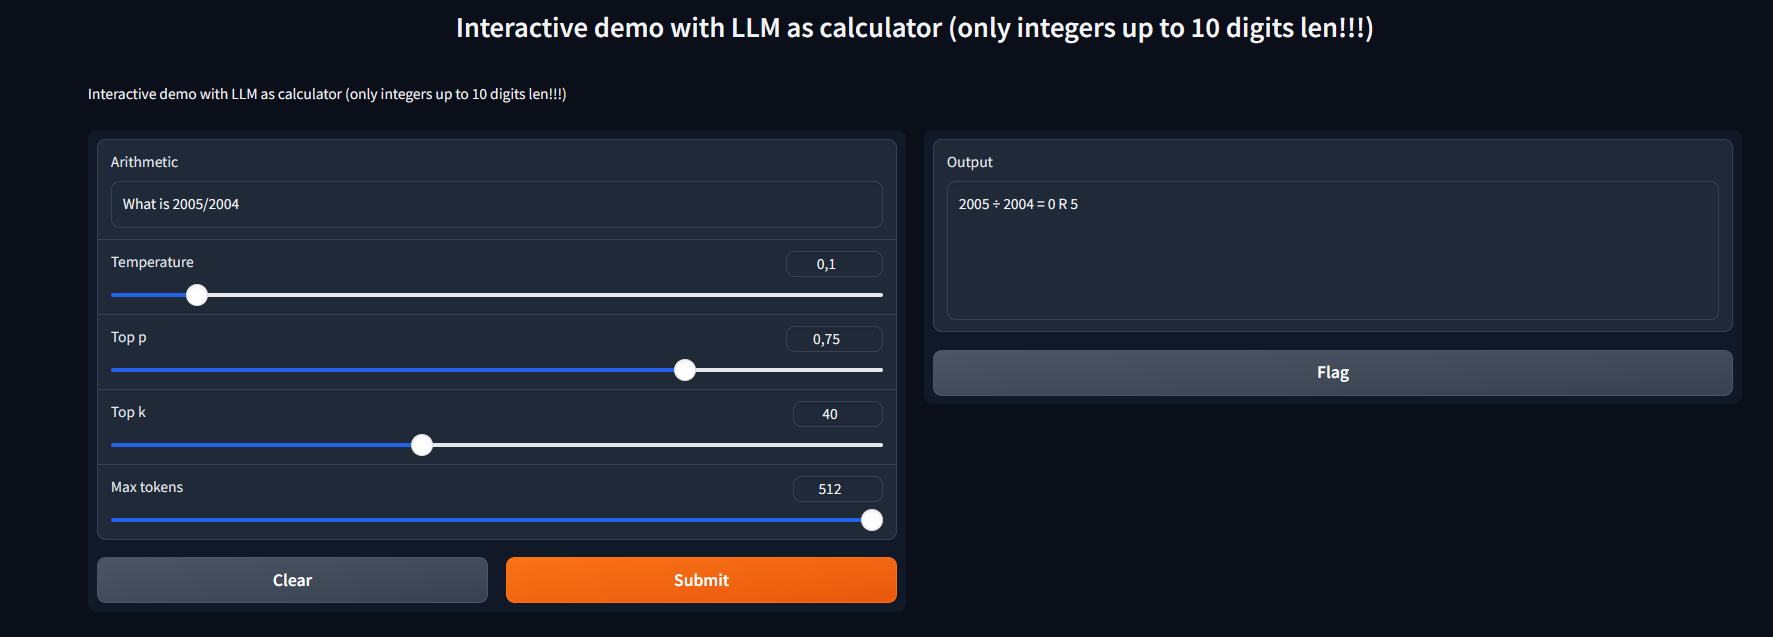
